In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tnrange
from sklearn.metrics import f1_score
import librosa
import pickle
import ast
import numpy as np
from scipy.fft import fft
import scipy
from tqdm.notebook import tqdm
from tensorflow.keras.layers import Input, LSTM, Dense,Masking,Concatenate,GlobalAveragePooling1D,Dropout,Conv2D,TimeDistributed,Conv1D,BatchNormalization,Activation
from tensorflow.keras.models import Model
import tensorflow as tf
import datetime
from sklearn.metrics import f1_score
%reload_ext tensorboard
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'
data=pd.read_csv('/content/train_tp.csv')

# Preprocessing

First, we will load the data using Librosa

In [ ]:
Signals=[] # This will contain the signals generated from audio files
for i in tnrange(data.shape[0]):
    path = '{}.flac'.format(data['recording_id'][i])
    audio_signal,sample_rate=librosa.load(path,sr=None) #Audio files are already encoded with sample rate of 
                                                   #  48000, so we don't need to resample them.
    signal=audio_signal[int(data['t_min'][i]*48000):int(data['t_max'][i]*48000)+1] # Slicing audio files with exact time as given in the csv file 
    if(data['t_min'][i]-0.2)<0: # Adding 0.2 second to the left and right of the time given and then slicing the file
        t1=0
    else:
        t1=int((data['t_min'][i]-0.2)*48000)

    if(data['t_max'][i]+0.2)>60:
        t2=60*48000
    else:
        t2=int((data['t_max'][i]+0.2)*48000)
    extended_signal=audio_signal[t1:t2]
    # Here we are slicing the audio files according to the time at which that species was heard.
    Signals.append(signal)
    Signals.append(extended_signal)

In [ ]:
# Now we have two files for each recording, so creating y_label accordingly
y_label=[]
for i in data['species_id']:
    y_label.append(i)
    y_label.append(i)
print(len(y_label))    

In [ ]:
# Now, we will do 80:20 stratified split for train and test
from sklearn.model_selection import train_test_split
y_train,y_test = train_test_split(pd.DataFrame(y_label),stratify=y_label,test_size=0.30,random_state=45)

# Splitting spectrogram data into train and test
train=[Signals[i] for i in y_train.index]
test=[Signals[i] for i in y_test.index]

In [ ]:
# Function for augmentation(We will apply augmentation only on train data) 
# We will apply two types of augmentation- Time stretch, pitch shift
def augmentation(samples):
    augmented_data = []
    n=np.random.uniform()
    if(n<0.25):
        data=librosa.effects.time_stretch(samples, rate=0.7)
    elif(n<0.5):
        data=librosa.effects.time_stretch(samples, rate=1.3)
    elif(n<0.75):
        data=librosa.effects.pitch_shift(samples, sr=48000, n_steps=-1)
    else:
        data=librosa.effects.pitch_shift(samples, sr=48000, n_steps=1)        
    augmented_data.append(data)
    return augmented_data

In [ ]:
aug_train=[]
for i in tnrange(len(train)):
    aug_train.append(train[i]) # Appending original data point
    aug_train.extend(augmentation(train[i])) # Appending augmented data point

In [ ]:
# Creating a new y_label according to our augmented data
new_y_train=[]
for i in y_train[0].values:
    new_y_train.extend(i for k in range(2))

In [ ]:
max_length=max([len(i) for i in aug_train])
print(max_length)

570776


In [ ]:
# Now we will write a function to convert raw data to spectrogram
def spectrogram(raw_signal):
    mel = librosa.feature.melspectrogram(y=raw_signal, sr=48000, n_mels=64)
    log_spec = librosa.power_to_db(S=mel, ref=np.max)
    return log_spec  

In [ ]:
# Now, we will write a function for padding our data to maximum length of audio sequence.
def pad(data):
    final_data=[]
    for k in tqdm(data):
        if(len(k)<max_length): # Checking if data has smaller length than maximum 
            k=list(k)
            k.extend(0 for i in range(max_length-len(k)))    # Appending 0s to the data
            final_data.append(spectrogram(np.array(k)))
        else:
            final_data.append(spectrogram(k)) 
    return final_data

In [ ]:
final_data=pad(aug_train) # Padding the data
test_data=pad(test)

In [ ]:
# Normalising train and test spectrogram data
mean=np.mean(train_data,(0,1,2))
std=np.std(train_data,(0,1,2))
train_spec=(train_data-mean)/std
test_spec=(test_data-mean)/std

So we are done with all the preprocessing, now we should move ahead with modelling.

# Modelling

Now, we will define the archtecture of the model. 

### Convolution Neural Network

In [ ]:
input_layer=Input(shape=(train_spec.shape[1],train_spec.shape[2]))
x=Conv1D(filters=24,kernel_size=5)(input_layer)
x=MaxPooling1D(strides=2)(x)
x=Activation('relu')(x)
x=Conv1D(filters=48,kernel_size=5)(x)
x=MaxPooling1D(strides=2)(x)
x=Activation('relu')(x)
x=Conv1D(filters=48,kernel_size=5)(x)
x=GlobalAveragePooling1D()(x)
x=Dense(64,activation='relu')(x) # Dense layer
x=Dropout(0.3)(x) # Dropout layer
output=Dense(24,activation='softmax')(x)

model = Model(inputs=[input_layer],outputs=output)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=tf.keras.optimizers.Adam()  # Optimizer
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics='accuracy')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 1115)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 24)            133824    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 24)            0         
_________________________________________________________________
activation (Activation)      (None, 30, 24)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 48)            5808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 48)            0         
_________________________________________________________________
activation_1 (Activation)    (None, 13, 48)            0     

In [ ]:
# Model training
model.fit(train_spec,y_train,epochs=400,validation_data=(test_spec,y_test),callbacks=[tensorboard_callback])

Epoch 1/400
107/107 [==============================] - 9s 16ms/step - loss: 2.9364 - accuracy: 0.1164 - val_loss: 2.1165 - val_accuracy: 0.2945
Epoch 2/400
107/107 [==============================] - 1s 10ms/step - loss: 2.3895 - accuracy: 0.2079 - val_loss: 1.8770 - val_accuracy: 0.3247
Epoch 3/400
107/107 [==============================] - 1s 9ms/step - loss: 2.2353 - accuracy: 0.2583 - val_loss: 1.6764 - val_accuracy: 0.3863
Epoch 4/400
107/107 [==============================] - 1s 9ms/step - loss: 2.0831 - accuracy: 0.2718 - val_loss: 1.4942 - val_accuracy: 0.4548
Epoch 5/400
107/107 [==============================] - 1s 10ms/step - loss: 1.9478 - accuracy: 0.3380 - val_loss: 1.4925 - val_accuracy: 0.4493
Epoch 6/400
107/107 [==============================] - 1s 10ms/step - loss: 1.8320 - accuracy: 0.3910 - val_loss: 1.3714 - val_accuracy: 0.5521
Epoch 7/400
107/107 [==============================] - 1s 9ms/step - loss: 1.7261 - accuracy: 0.4289 - val_loss: 1.2235 - val_accuracy: 0.

KeyboardInterrupt: ignored

We have trained our model and checked it's performance using cross entropy and accuracy, both of which indicated good performance.        
Now, we will try a different model architecture to see if it can increase performance.

### LSTM Model-

In [ ]:
## as discussed above, please write the LSTM
!rm -rf ./logs/
input_layer=Input(shape=(train_spec.shape[1],train_spec.shape[2]))   # Input layer
lstm_layer=LSTM(units=50,return_sequences=True)(input_layer)  # LSTM layer with 25 units
average=GlobalAveragePooling1D()(lstm_layer) #Global average pool
layer_1=Dense(32,activation='relu')(average) # Dense layer
drop=Dropout(0.3)(layer_1) # Dropout layer
output=Dense(24,activation='softmax')(drop) # output layer

model_spec = Model(inputs=[input_layer],outputs=output)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=tf.keras.optimizers.Adam()  # Optimizer
model_spec.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics='accuracy')


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 1115)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 24)            133824    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 24)            0         
_________________________________________________________________
activation (Activation)      (None, 30, 24)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 48)            5808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 48)            0         
_________________________________________________________________
activation_1 (Activation)    (None, 13, 48)            0     

In [ ]:
# Model training
model_spec.fit(train_spec,y_train,epochs=300,validation_data=(test_spec,y_test),callbacks=[tensorboard_callback])

Epoch 1/300
107/107 [==============================] - 4s 21ms/step - loss: 2.8812 - accuracy: 0.1661 - val_loss: 2.2963 - val_accuracy: 0.2863
Epoch 2/300
107/107 [==============================] - 1s 13ms/step - loss: 2.4065 - accuracy: 0.2536 - val_loss: 1.9307 - val_accuracy: 0.3849
Epoch 3/300
107/107 [==============================] - 1s 12ms/step - loss: 2.1896 - accuracy: 0.2885 - val_loss: 1.6625 - val_accuracy: 0.4438
Epoch 4/300
107/107 [==============================] - 1s 12ms/step - loss: 2.0391 - accuracy: 0.3299 - val_loss: 1.5908 - val_accuracy: 0.4767
Epoch 5/300
107/107 [==============================] - 1s 12ms/step - loss: 1.9396 - accuracy: 0.3673 - val_loss: 1.4370 - val_accuracy: 0.5014
Epoch 6/300
107/107 [==============================] - 1s 12ms/step - loss: 1.8456 - accuracy: 0.3938 - val_loss: 1.3717 - val_accuracy: 0.5932
Epoch 7/300
107/107 [==============================] - 1s 13ms/step - loss: 1.7972 - accuracy: 0.4002 - val_loss: 1.2973 - val_accuracy:

KeyboardInterrupt: ignored

This model also gives us similar performance. Let's use a model architecture that uses both LSTM and Conv and see if it performs better.

### Conv + LSTM Network

In [ ]:
input_layer=Input(shape=(train_spec.shape[1],train_spec.shape[2]))   # Input layer
lstm_layer=LSTM(units=50,return_sequences=True)(input_layer)  # LSTM layer with 25 units
average=GlobalAveragePooling1D()(lstm_layer) #Global average pool
layer_1=Dense(32,activation='relu')(average) # Dense layer


x=Conv1D(filters=24,kernel_size=5)(input_layer)
x=MaxPooling1D(strides=2)(x)
x=Activation('relu')(x)
x=Conv1D(filters=48,kernel_size=5)(x)
x=MaxPooling1D(strides=2)(x)
x=Activation('relu')(x)
x=Conv1D(filters=48,kernel_size=5)(x)
x=GlobalAveragePooling1D()(x)
x=Dense(64,activation='relu')(x) # Dense layer


x=Concatenate()([layer_1,x])
x=Dense(64)(x)
x=Dropout(0.3)(x)
output=Dense(24,activation='softmax')(x)

model = Model(inputs=[input_layer],outputs=output)
optimizer=tf.keras.optimizers.Adam()  # Optimizer
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics='accuracy')

In [ ]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 64, 1115)]   0                                            
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 60, 24)       133824      input_26[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_18 (MaxPooling1D) (None, 30, 24)       0           conv1d_30[0][0]                  
__________________________________________________________________________________________________
activation_29 (Activation)      (None, 30, 24)       0           max_pooling1d_18[0][0]           
____________________________________________________________________________________________

In [ ]:
# Model training

model.fit(train_spec,y_train,epochs=300,validation_data=(test_spec,y_test),callbacks=[tensorboard_callback])

Epoch 1/300
107/107 [==============================] - 4s 22ms/step - loss: 2.6507 - accuracy: 0.1816 - val_loss: 1.7868 - val_accuracy: 0.3644
Epoch 2/300
107/107 [==============================] - 2s 16ms/step - loss: 2.1241 - accuracy: 0.2788 - val_loss: 1.4596 - val_accuracy: 0.5082
Epoch 3/300
107/107 [==============================] - 2s 15ms/step - loss: 1.8381 - accuracy: 0.3802 - val_loss: 1.3912 - val_accuracy: 0.4712
Epoch 4/300
107/107 [==============================] - 2s 15ms/step - loss: 1.8000 - accuracy: 0.4004 - val_loss: 1.1852 - val_accuracy: 0.6137
Epoch 5/300
107/107 [==============================] - 2s 15ms/step - loss: 1.6084 - accuracy: 0.4723 - val_loss: 1.1163 - val_accuracy: 0.6493
Epoch 6/300
107/107 [==============================] - 2s 15ms/step - loss: 1.5043 - accuracy: 0.5064 - val_loss: 1.0307 - val_accuracy: 0.6740
Epoch 7/300
107/107 [==============================] - 2s 15ms/step - loss: 1.4009 - accuracy: 0.5173 - val_loss: 0.9267 - val_accuracy:

This model's performance is slightly better than previous two models.

Let's check our model's performance using using label_ranking_average_precision_score to evaluate submissions.
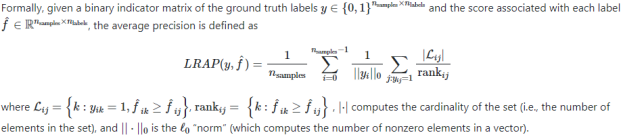

Or in easy language, we can define it as-     
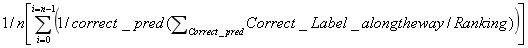

In [ ]:
# Converting y_label to one hot encoded
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
true=enc.fit_transform(y_test)
true=true.toarray()

In [ ]:
# Making prediction on our test data and checking label_ranking_average_precision_score
pred=[model_spec.predict(i.reshape(1,64,1115))[0] for i in test_spec]
from sklearn.metrics import label_ranking_average_precision_score
label_ranking_average_precision_score(true,pred)

0.9638850837138507

This is good, our model is performing very well !

## Summary of our work till now
1. First we did a detailed EDA of our data and found some useful information which we later used during model preprocessing and modelling.
2. Later, to preprocess our data we loaded the data using Librosa using sampling rate of 48000.
3. We split our data into train and test(70:30). 
4. We added 0.2 seconds to left and right of the given timeframe and did data augmentation to make our model more generalised and robust.(Augmentation was only applied to training data).
5. We converted our data from time domain to frequency domain by converting it to spectrograms.
6. We normalised our data.
7. We tried different neural network architecture to check which performs better.

In [2]:
from prettytable import PrettyTable
x = PrettyTable()
x = PrettyTable(["Model", "Multi class logloss","Accuracy"])
row1= ['Convolution Model',0.21,95]
row2 = ['LSTM Model',0.17,93]
row3 = ['Conv + LSTM Model',0.15,97]
x.add_row(row1)
x.add_row(row2)
x.add_row(row3)

print(x)

+-------------------+---------------------+----------+
|       Model       | Multi class logloss | Accuracy |
+-------------------+---------------------+----------+
| Convolution Model |         0.21        |    95    |
|     LSTM Model    |         0.17        |    93    |
| Conv + LSTM Model |         0.15        |    97    |
+-------------------+---------------------+----------+


First, we tried with Convolution based neural network which performed quite good.<br>
LSTM based network gave us better logloss but accuracy decreased slightly.<br>
LSTM + Conv network performed best of them all and logloss and accuracy both got better than our previous model. 